In [1]:
### TODO:
#   - najdi primerni podatkovni bazi za regresijo in klasifikacijo
#   - omogoči naključno rezanje uteži
#   - ustvari lažje podajanje hiperparametrov
#   - !!ročno inicializiraj uteži z Gaussian Glorot initialization ALI Gaussian z standard deviation 0.1
#   - ustvari lepši ui, ki na boljši način prikaže rezanje in učenje.
#   - podatke kot je early stopping rate, natančnost itd. itd. je treba nekje shraniti in prikazati
#   - sproti shranjuj nekatere modele npr. najbolj natančnega, najbolj rezanega ali po vsakem rezanju

In [2]:
import torch
import numpy as np
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchinfo
import matplotlib
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter

from neural_network import *
from iterative_pruning import IterativePruning

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
NUM_CHANNELS = 10
BATCH_SIZE = 128
NUM_EPOCHS = 100
IMAGE_SIZE = [28, 28]
LR = 1.2e-3

In [5]:
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
])

##pin_memory in num_workers=6

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

train_subset, val_subset = torch.utils.data.random_split(mnist_trainset, [50000, 10000], generator=torch.Generator().manual_seed(1))

X_train = train_subset.dataset.data[train_subset.indices]
y_train = train_subset.dataset.targets[train_subset.indices]

X_val = val_subset.dataset.data[val_subset.indices]
y_val = val_subset.dataset.targets[val_subset.indices]

train_loader = DataLoader(dataset=train_subset, shuffle=True, batch_size=BATCH_SIZE)
val_loader = DataLoader(dataset=val_subset, shuffle=False, batch_size=BATCH_SIZE)

mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(mnist_testset, batch_size=BATCH_SIZE, shuffle=True)

Ime zbirke:     MNIST
Velikost učne množice:   60000
Velikost testne množice:   10000
Dimenzija slik: (1, 28, 28)


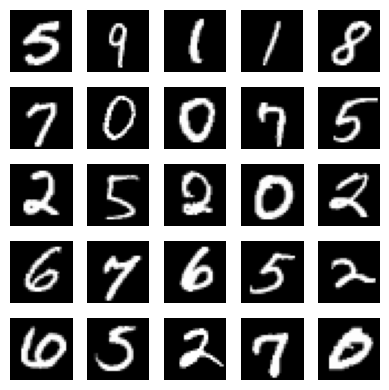

In [6]:
images, _ = next(iter(train_loader))

print(f"Ime zbirke:     MNIST")
print(f"Velikost učne množice:   {len(mnist_trainset)}")
print(f"Velikost testne množice:   {len(mnist_testset)}")
print(f"Dimenzija slik: {images[0].numpy().shape}")

_, axes = plt.subplots(5, 5, figsize=(4, 4), squeeze=False)
for i in range(5):
    for j in range(5):
        axes[i, j].imshow(images[5*i+j].numpy().transpose((1,2,0)), cmap="gray")
        axes[i, j].axis("off")
            
plt.tight_layout()

In [7]:
model = LeNet300(NUM_CHANNELS)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = torch.nn.CrossEntropyLoss()

print(torchinfo.summary(model, (BATCH_SIZE, 1, IMAGE_SIZE[1], IMAGE_SIZE[0])))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet300                                 [128, 10]                 --
├─Linear: 1-1                            [128, 300]                235,500
├─ReLU: 1-2                              [128, 300]                --
├─Linear: 1-3                            [128, 100]                30,100
├─ReLU: 1-4                              [128, 100]                --
├─Linear: 1-5                            [128, 10]                 1,010
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
Total mult-adds (M): 34.13
Input size (MB): 0.40
Forward/backward pass size (MB): 0.42
Params size (MB): 1.07
Estimated Total Size (MB): 1.89


In [8]:
for i, data in enumerate(model.named_parameters()):
    name, param = data
    if "weight" in name:
        print(name)
        print(np.shape(param.data))

linear_1.weight
torch.Size([300, 784])
linear_2.weight
torch.Size([100, 300])
linear_3.weight
torch.Size([10, 100])


In [9]:
ip = IterativePruning(model)

ip.start(loss_fn, train_loader, val_loader, test_loader, LR, NUM_EPOCHS, 2, 0, 0.2)

 ===| Prune iteration 1/30 |=== 
Name                    Zeros Nonzeros      All Nonzeros(%)
linear_1.weight             0   235200   235200     100.00%
linear_1.bias               0      300      300     100.00%
linear_2.weight             0    30000    30000     100.00%
linear_2.bias               0      100      100     100.00%
linear_3.weight             0     1000     1000     100.00%
linear_3.bias               0       10       10     100.00%
all                         0   266610   266610     100.00%


Epoch: 7, loss: 0.0212, val_loss: 0.0845 Validating: : 79it [00:01, 51.01it/s]                       
Testing: 79it [00:02, 32.27it/s]                        


Accuracy: 0.974


 ===| Prune iteration 2/30 |=== 
Name                    Zeros Nonzeros      All Nonzeros(%)
linear_1.weight         47040   188160   235200      80.00%
linear_1.bias               0      300      300     100.00%
linear_2.weight          6000    24000    30000      80.00%
linear_2.bias               0      100      100     100.00%
linear_3.weight           100      900     1000      90.00%
linear_3.bias               0       10       10     100.00%
all                     53140   213470   266610      80.07%


Epoch: 6, loss: 0.0206, val_loss: 0.0841 Validating: : 79it [00:01, 46.34it/s]                       
Testing: 79it [00:02, 31.63it/s]                        


Accuracy: 0.978


 ===| Prune iteration 3/30 |=== 
Name                    Zeros Nonzeros      All Nonzeros(%)
linear_1.weight         84672   150528   235200      64.00%
linear_1.bias               0      300      300     100.00%
linear_2.weight         10800    19200    30000      64.00%
linear_2.bias               0      100      100     100.00%
linear_3.weight           190      810     1000      81.00%
linear_3.bias               0       10       10     100.00%
all                     95662   170948   266610      64.12%


Epoch: 4, loss: 0.0278, val_loss: 0.0820 Validating: : 79it [00:01, 50.32it/s]                       
Testing: 79it [00:02, 31.80it/s]                        


Accuracy: 0.978


 ===| Prune iteration 4/30 |=== 
Name                    Zeros Nonzeros      All Nonzeros(%)
linear_1.weight        114777   120423   235200      51.20%
linear_1.bias               0      300      300     100.00%
linear_2.weight         14640    15360    30000      51.20%
linear_2.bias               0      100      100     100.00%
linear_3.weight           271      729     1000      72.90%
linear_3.bias               0       10       10     100.00%
all                    129688   136922   266610      51.36%


Epoch: 4, loss: 0.0237, val_loss: 0.0779 Validating: : 79it [00:01, 53.52it/s]                       
Testing: 79it [00:02, 32.85it/s]                        


Accuracy: 0.977


 ===| Prune iteration 5/30 |=== 
Name                    Zeros Nonzeros      All Nonzeros(%)
linear_1.weight        138861    96339   235200      40.96%
linear_1.bias               0      300      300     100.00%
linear_2.weight         17712    12288    30000      40.96%
linear_2.bias               0      100      100     100.00%
linear_3.weight           343      657     1000      65.70%
linear_3.bias               0       10       10     100.00%
all                    156916   109694   266610      41.14%


Epoch: 3, loss: 0.0296, val_loss: 0.0798 Validating: : 79it [00:01, 50.52it/s]                       
Testing: 79it [00:02, 30.73it/s]                        


Accuracy: 0.979


 ===| Prune iteration 6/30 |=== 
Name                    Zeros Nonzeros      All Nonzeros(%)
linear_1.weight        158128    77072   235200      32.77%
linear_1.bias               0      300      300     100.00%
linear_2.weight         20169     9831    30000      32.77%
linear_2.bias               0      100      100     100.00%
linear_3.weight           408      592     1000      59.20%
linear_3.bias               0       10       10     100.00%
all                    178705    87905   266610      32.97%


Epoch: 5, loss: 0.0133, val_loss: 0.0715 Validating: : 79it [00:01, 49.75it/s]                       
Testing: 79it [00:02, 31.13it/s]                        


Accuracy: 0.980


 ===| Prune iteration 7/30 |=== 
Name                    Zeros Nonzeros      All Nonzeros(%)
linear_1.weight        173542    61658   235200      26.22%
linear_1.bias               0      300      300     100.00%
linear_2.weight         22135     7865    30000      26.22%
linear_2.bias               0      100      100     100.00%
linear_3.weight           467      533     1000      53.30%
linear_3.bias               0       10       10     100.00%
all                    196144    70466   266610      26.43%


Epoch: 6, loss: 0.0069, val_loss: 0.0729 Validating: : 79it [00:01, 50.56it/s]                       
Testing: 79it [00:02, 31.94it/s]                        


Accuracy: 0.978


 ===| Prune iteration 8/30 |=== 
Name                    Zeros Nonzeros      All Nonzeros(%)
linear_1.weight        185873    49327   235200      20.97%
linear_1.bias               0      300      300     100.00%
linear_2.weight         23708     6292    30000      20.97%
linear_2.bias               0      100      100     100.00%
linear_3.weight           520      480     1000      48.00%
linear_3.bias               0       10       10     100.00%
all                    210101    56509   266610      21.20%


Epoch: 6, loss: 0.0071, val_loss: 0.0704 Validating: : 79it [00:01, 51.56it/s]                       
Testing: 79it [00:02, 31.58it/s]                        


Accuracy: 0.981


 ===| Prune iteration 9/30 |=== 
Name                    Zeros Nonzeros      All Nonzeros(%)
linear_1.weight        195738    39462   235200      16.78%
linear_1.bias               0      300      300     100.00%
linear_2.weight         24966     5034    30000      16.78%
linear_2.bias               0      100      100     100.00%
linear_3.weight           568      432     1000      43.20%
linear_3.bias               0       10       10     100.00%
all                    221272    45338   266610      17.01%


Epoch: 5, loss: 0.0111, val_loss: 0.0685 Validating: : 79it [00:01, 51.24it/s]                       
Testing: 79it [00:02, 31.61it/s]                        


Accuracy: 0.980


 ===| Prune iteration 10/30 |=== 
Name                    Zeros Nonzeros      All Nonzeros(%)
linear_1.weight        203630    31570   235200      13.42%
linear_1.bias               0      300      300     100.00%
linear_2.weight         25972     4028    30000      13.43%
linear_2.bias               0      100      100     100.00%
linear_3.weight           611      389     1000      38.90%
linear_3.bias               0       10       10     100.00%
all                    230213    36397   266610      13.65%


Epoch: 6, loss: 0.0105, val_loss: 0.0720 Validating: : 79it [00:01, 49.23it/s]                       
Testing: 79it [00:02, 31.64it/s]                        


Accuracy: 0.981


 ===| Prune iteration 11/30 |=== 
Name                    Zeros Nonzeros      All Nonzeros(%)
linear_1.weight        209944    25256   235200      10.74%
linear_1.bias               0      300      300     100.00%
linear_2.weight         26777     3223    30000      10.74%
linear_2.bias               0      100      100     100.00%
linear_3.weight           649      351     1000      35.10%
linear_3.bias               0       10       10     100.00%
all                    237370    29240   266610      10.97%


Epoch: 7, loss: 0.0089, val_loss: 0.0693 Validating: : 79it [00:01, 49.58it/s]                       
Testing: 79it [00:02, 31.58it/s]                        


Accuracy: 0.979


 ===| Prune iteration 12/30 |=== 
Name                    Zeros Nonzeros      All Nonzeros(%)
linear_1.weight        214995    20205   235200       8.59%
linear_1.bias               0      300      300     100.00%
linear_2.weight         27421     2579    30000       8.60%
linear_2.bias               0      100      100     100.00%
linear_3.weight           684      316     1000      31.60%
linear_3.bias               0       10       10     100.00%
all                    243100    23510   266610       8.82%


Epoch: 7, loss: 0.0113, val_loss: 0.0700 Validating: : 79it [00:01, 50.76it/s]                       
Testing: 79it [00:02, 32.20it/s]                        


Accuracy: 0.980


 ===| Prune iteration 13/30 |=== 
Name                    Zeros Nonzeros      All Nonzeros(%)
linear_1.weight        219036    16164   235200       6.87%
linear_1.bias               0      300      300     100.00%
linear_2.weight         27936     2064    30000       6.88%
linear_2.bias               0      100      100     100.00%
linear_3.weight           715      285     1000      28.50%
linear_3.bias               0       10       10     100.00%
all                    247687    18923   266610       7.10%


Epoch: 6, loss: 0.0197, val_loss: 0.0705 Validating: : 79it [00:01, 49.48it/s]                       
Testing: 79it [00:02, 31.24it/s]                        


Accuracy: 0.980


 ===| Prune iteration 14/30 |=== 
Name                    Zeros Nonzeros      All Nonzeros(%)
linear_1.weight        222268    12932   235200       5.50%
linear_1.bias               0      300      300     100.00%
linear_2.weight         28348     1652    30000       5.51%
linear_2.bias               0      100      100     100.00%
linear_3.weight           743      257     1000      25.70%
linear_3.bias               0       10       10     100.00%
all                    251359    15251   266610       5.72%


Epoch: 7, loss: 0.0216, val_loss: 0.0716 Validating: : 79it [00:01, 51.14it/s]                       
Testing: 79it [00:02, 32.11it/s]                        


Accuracy: 0.981


 ===| Prune iteration 15/30 |=== 
Name                    Zeros Nonzeros      All Nonzeros(%)
linear_1.weight        224854    10346   235200       4.40%
linear_1.bias               0      300      300     100.00%
linear_2.weight         28678     1322    30000       4.41%
linear_2.bias               0      100      100     100.00%
linear_3.weight           768      232     1000      23.20%
linear_3.bias               0       10       10     100.00%
all                    254300    12310   266610       4.62%


Epoch: 9, loss: 0.0209, val_loss: 0.0744 Validating: : 79it [00:01, 51.47it/s]                       
Testing: 79it [00:02, 31.48it/s]                        


Accuracy: 0.980


 ===| Prune iteration 16/30 |=== 
Name                    Zeros Nonzeros      All Nonzeros(%)
linear_1.weight        226923     8277   235200       3.52%
linear_1.bias               0      300      300     100.00%
linear_2.weight         28942     1058    30000       3.53%
linear_2.bias               0      100      100     100.00%
linear_3.weight           791      209     1000      20.90%
linear_3.bias               0       10       10     100.00%
all                    256656     9954   266610       3.73%


Epoch: 10, loss: 0.0226, val_loss: 0.0754 Validating: : 79it [00:01, 50.71it/s]                      
Testing: 79it [00:02, 31.21it/s]                        


Accuracy: 0.979


 ===| Prune iteration 17/30 |=== 
Name                    Zeros Nonzeros      All Nonzeros(%)
linear_1.weight        228578     6622   235200       2.82%
linear_1.bias               0      300      300     100.00%
linear_2.weight         29153      847    30000       2.82%
linear_2.bias               0      100      100     100.00%
linear_3.weight           811      189     1000      18.90%
linear_3.bias               0       10       10     100.00%
all                    258542     8068   266610       3.03%


Epoch: 7, loss: 0.0391, val_loss: 0.0781 Training:   0%|          | 0/390 [00:00<?, ?it/s]           

In [ ]:
#model = torch.load("model_lenet_mnist.pt")
#test(model, test_loader, len(mnist_testset))